In [43]:
from functools import partial
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly
from ipywidgets import fixed
from ipywidgets import widgets
from plotly import tools
from pyproj import Proj, transform
import datashader as ds

import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy

plotly.offline.init_notebook_mode(connected=True)

base_dir = '/Users/Olga/Desktop/pluto/'

bk = pd.read_csv(base_dir + 'BK2017V11.csv')
bx = pd.read_csv(base_dir + 'BX2017V11.csv')
mn = pd.read_csv(base_dir + 'MN2017V11.csv')
qn = pd.read_csv(base_dir + 'QN2017V11.csv')
si = pd.read_csv(base_dir + 'SI2017V11.csv')
ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True) 

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]


# Q1 :After a few building collapses, the City of New York is going to begin investigating older buildings for safety.
# The city is particularly worried about buildings that were unusually tall when they were built, since 
# best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain 
# number of floors were built in each year (note: you may want to use a log scale for the number of buildings). 
# Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story 
# buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

def binner(entry, step, max):
    curr_val = int(step * np.floor(entry / step))
    if curr_val <= max:
        return str(curr_val + 1) + ' to ' + str(curr_val + 10)
    else:
        return 'taller than ' + str(max)


def visualize(height_bin,global_stories_step, global_stories_max, global_year_step):
    ny['stories'] = ny['NumFloors'].apply(binner, step=global_stories_step, max=global_stories_max)
    height_specific = ny.loc[lambda df: df.stories == height_bin, :]
    height_specific['periodBuilt'] = height_specific['YearBuilt'].apply(binner, step=global_year_step, max=3000)
    ny_clean = height_specific[['stories', 'periodBuilt']]
    ny_storiesAndYear = ny_clean.groupby(['periodBuilt'])['stories'].count()
    layout = go.Layout(
        yaxis=dict(title='Number of Buildings Built')
    )

    trace = go.Scatter(
                name=height_bin + ' stories tall',
                x=ny_storiesAndYear.index,
                y=ny_storiesAndYear
            )


    fig = go.Figure(data=[trace], layout=layout)

    plotly.offline.iplot(fig)

height = widgets.Dropdown(options=["1 to 10", "11 to 20", "21 to 30", "31 to 40", "41 to 50", "taller than 50"],
                            value="1 to 10", description='stories')


widgets.interact(visualize, height_bin=height, global_stories_step=fixed(10), global_stories_max=fixed(50), global_year_step=fixed(10))


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (19,20,22,24,26) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (19,20,22,24,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

/a

interactive(children=(Dropdown(description='stories', options=('1 to 10', '11 to 20', '21 to 30', '31 to 40', …

<function __main__.visualize(height_bin, global_stories_step, global_stories_max, global_year_step)>

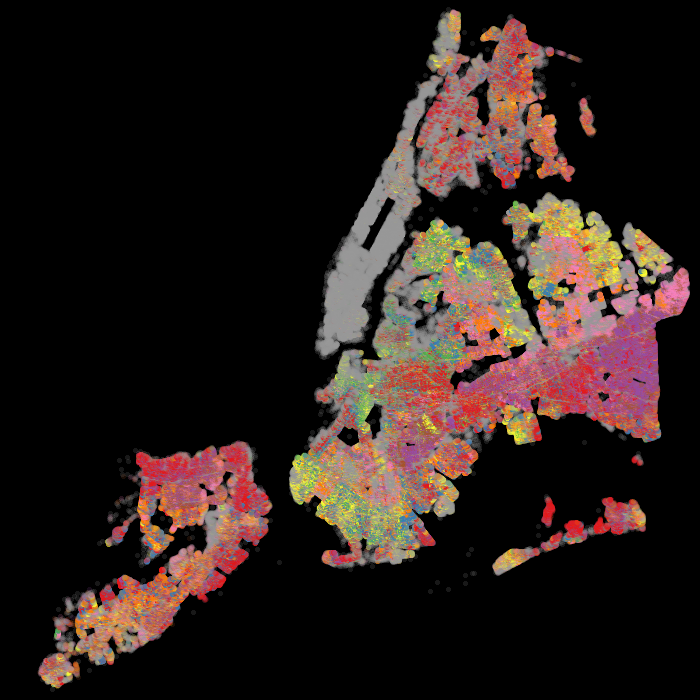

In [44]:
# Q2
# You work for a real estate developer and are researching underbuilt areas of the city. After looking in the 
# Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the 
# land and assessment of the structure. You reason that there should be a correlation between these two values: 
# more valuable land will have more valuable structures on them (more valuable in this case refers not just to a 
# mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent 
# underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate.
# choropleth maps, and think the technique could be used for this problem.

wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj(
    "+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048 * ny['XCoord']
ny['YCoord'] = 0.3048 * ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

ny['AssessStruct'] = ny['AssessTot'] - ny['AssessLand']

al33 = np.percentile(ny['AssessLand'].values, 33)
al66 = np.percentile(ny['AssessLand'].values, 66)
as33 = np.percentile(ny['AssessStruct'].values, 33)
as66 = np.percentile(ny['AssessStruct'].values, 66)

ny['AssessLand3tile'] = ny['AssessLand'].apply(lambda x: 1 if x < al33 else 2 if x < al66 else 3)
ny['AssessStruct3tile'] = ny['AssessStruct'].apply(lambda x: 1 if x < as33 else 2 if x < as66 else 3)

ny['AssessAll3tile'] = ny['AssessLand3tile'].apply(str) + ny['AssessStruct3tile'].apply(str) + 'c'

ny['AssessAll3tile'] = pd.Categorical(ny['AssessAll3tile'])


NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.count_cat('AssessAll3tile'))
view = tf.shade(agg)
export(tf.spread(view, px=2), 'bivariate')